# Time Series

**Inhalt:** Zeitreihen analysieren Like a Boss

**Nötige Skills:** Daten explorieren, Time+Date Basics

**Lernziele:**
- Datetime-Datentyp anwenden
- Auswertungsmöglichkeiten für zeitbezogene Daten kennenlernen
- Plotting Level 3

**Weitere Ressourcen:**
- https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html

## Das Beispiel

Die Zeit ist eine Dimension, die in vielen Datensets vorkommt.

Ein typischer Anwendungsfall sind Finanzdaten. Wir analysieren in diesem Notebook eine einzige Grösse: den Schweizer Aktienindex SMI. Die Daten dazu sind auf täglicher Basis frei verfügbar, ab 1989.

Quelle: https://www.six-group.com/exchanges/indices/data_centre/shares/smi_de.html

Wir werden in diesem Notebook verschiedene Techniken kennenlernen:
- Aus der Gesamtmenge die Zeitperioden auswählen, die uns interessieren
- Daten für verschiedene Zeiträume aggregieren (zB Monate)
- Daten für verschiedene Zeiträume gruppieren (das ist nicht dasselbe)
- Daten-Veränderungen berechnen und darstellen
- Trends erkennen und Daten glätten

Diverse von diesen Techniken kommen üblicherweise zur Anwendungen, wenn man aus einer Zeitreihe eine Story generieren will, und wenn es darum geht, die Daten angemessen darzustellen.

## Vorbereitung

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
%matplotlib inline

## Daten einlesen

Die Daten sind bereits gespeichert unter `dataprojects/SMI/smi_only.csv`

In [4]:
df = pd.read_csv('dataprojects/SMI/smi_only.csv', delimiter=';')

In [5]:
df.head(2)

,Date,Open,Close,High,Low
0,12.10.2018,8702.13,8660.38,8738.78,8660.25
1,11.10.2018,8760.52,8639.19,8796.87,8628.65


Wie üblich, Typen abchecken

In [6]:
df.dtypes

Date      object
Open     float64
Close    float64
High      object
Low      float64
dtype: object

Spalte "High" genauer anschauen

In [7]:
df['High'].value_counts()

           6
1491.7     4
1728.3     3
1653.1     3
1692.5     3
1688.9     3
1713.1     3
1804.5     3
1724.7     3
2610       3
1829       3
8384.3     2
1604.5     2
2617.7     2
2604.6     2
2625.8     2
5826.84    2
9283.28    2
7178.1     2
1708.2     2
2625.3     2
1668.2     2
1830.2     2
1627.7     2
1484.9     2
7443.2     2
3678.5     2
7021.6     2
3161.7     2
1732.1     2
          ..
1918.7     1
8231.54    1
9349.18    1
8137.41    1
7922.9     1
2534.9     1
6906.61    1
5799.99    1
5789.57    1
8818.69    1
7870.62    1
9385.66    1
4865.72    1
7978       1
9265.85    1
9422.28    1
7543.71    1
8724.12    1
8550.84    1
7089.5     1
7760       1
8957.81    1
2600.1     1
7974.36    1
1661       1
7952.13    1
1996.7     1
9306.89    1
8886.03    1
6476.24    1
Name: High, Length: 7284, dtype: int64

Es hat einige Leerzeichen drin

In [8]:
df['High'].value_counts().head(1).index

Index([' '], dtype='object')

Wir können die Datei nochmals einlesen mit `na_values=`

In [9]:
df = pd.read_csv('dataprojects/SMI/smi_only.csv', delimiter=';', na_values=' ')

# na_values gleich Leerschlag, hier sagen wir formatiere das als NaN

In [10]:
df.head(2)

,Date,Open,Close,High,Low
0,12.10.2018,8702.13,8660.38,8738.78,8660.25
1,11.10.2018,8760.52,8639.19,8796.87,8628.65


In [11]:
df.dtypes

Date      object
Open     float64
Close    float64
High     float64
Low      float64
dtype: object

Nochmals etwas genauer abchecken:

In [12]:
df.describe()

,Open,Close,High,Low
count,7480.000000,7480.000000,7474.000000,7480.000000
mean,5808.371451,5807.904520,5847.168964,5769.384362
std,2446.528872,2445.419499,2454.735349,2436.928060
min,1288.700000,1287.600000,1296.600000,0.000000
25%,3643.125000,3645.625000,3666.200000,3623.925000
50%,6309.075000,6311.865000,6357.550000,6265.790000
75%,7870.735000,7863.675000,7906.162500,7823.397500
max,9588.480000,9611.610000,9616.380000,9554.480000


In der Spalte "Low" gibt es offenbar einige Werte, die nicht stimmen können... (die Börse ging hoffentlich nie auf 0 runter)

In [13]:
df['Low'].value_counts().head()

0.0       8
1689.8    3
1697.8    3
1750.6    3
3121.2    2
Name: Low, dtype: int64

Was waren das für Zeitpunkte?

In [14]:
df[df['Low'] == 0]

,Date,Open,Close,High,Low
6957,11.02.1991,1497.7,1515.7,1516.8,0.0
6988,21.12.1990,1367.4,1387.9,1389.7,0.0
7244,11.12.1989,1781.4,1783.3,NaN,0.0
7333,07.08.1989,1820.0,1829.4,1832.6,0.0
7342,24.07.1989,1761.3,1764.3,1764.8,0.0
7357,03.07.1989,1641.2,1653.1,1653.1,0.0
7393,11.05.1989,1528.7,1528.7,NaN,0.0
7438,01.03.1989,1451.4,1460.8,1469.8,0.0


Wir korrigieren das... speichern zur Sicherheit nochmals kurz die Index-Zahlen ab

In [15]:
low_nullen = df[df['Low'] == 0].index

In [18]:
df.loc[low_nullen]
# df.loc zum Zwischenkontrollieren

,Date,Open,Close,High,Low
6957,11.02.1991,1497.7,1515.7,1516.8,NaN
6988,21.12.1990,1367.4,1387.9,1389.7,NaN
7244,11.12.1989,1781.4,1783.3,NaN,NaN
7333,07.08.1989,1820.0,1829.4,1832.6,NaN
7342,24.07.1989,1761.3,1764.3,1764.8,NaN
7357,03.07.1989,1641.2,1653.1,1653.1,NaN
7393,11.05.1989,1528.7,1528.7,NaN,NaN
7438,01.03.1989,1451.4,1460.8,1469.8,NaN


In [19]:
df['Low'].replace(0, np.nan, inplace=True)
#alle Nullen werden durch NaNs ersetzt, inplace=True bedeutet dass der Befehl auf dem aktuellen Dataframe gemacht wird

Check ob es funktioniert hat (wir nutzen die zwischengespeicherten Index-Zahlen)

In [20]:
df.loc[low_nullen]

,Date,Open,Close,High,Low
6957,11.02.1991,1497.7,1515.7,1516.8,NaN
6988,21.12.1990,1367.4,1387.9,1389.7,NaN
7244,11.12.1989,1781.4,1783.3,NaN,NaN
7333,07.08.1989,1820.0,1829.4,1832.6,NaN
7342,24.07.1989,1761.3,1764.3,1764.8,NaN
7357,03.07.1989,1641.2,1653.1,1653.1,NaN
7393,11.05.1989,1528.7,1528.7,NaN,NaN
7438,01.03.1989,1451.4,1460.8,1469.8,NaN


In [21]:
df.describe()

,Open,Close,High,Low
count,7480.000000,7480.000000,7474.000000,7472.000000
mean,5808.371451,5807.904520,5847.168964,5775.561433
std,2446.528872,2445.419499,2454.735349,2430.904493
min,1288.700000,1287.600000,1296.600000,1279.000000
25%,3643.125000,3645.625000,3666.200000,3635.225000
50%,6309.075000,6311.865000,6357.550000,6267.860000
75%,7870.735000,7863.675000,7906.162500,7823.842500
max,9588.480000,9611.610000,9616.380000,9554.480000


Jetzt sind wir ready! - fast.

## Daten Arrangieren

Bevor es losgeht mit analysieren, erstellen wir uns eine ordentliche Datums-Spalte.

Und zwar eine, die den Datentyp "Datetime" hat!

In [29]:
df['New Date'] = pd.to_datetime(df['Date'], format="%d.%m.%Y")

In [30]:
df.head(2)

,Date,Open,Close,High,Low,New Date
New Date,,,,,,
2018-10-12,12.10.2018,8702.13,8660.38,8738.78,8660.25,2018-10-12
2018-10-11,11.10.2018,8760.52,8639.19,8796.87,8628.65,2018-10-11


In [31]:
df.dtypes

Date                object
Open               float64
Close              float64
High               float64
Low                float64
New Date    datetime64[ns]
dtype: object

Wir setzen diese Spalte nun als Index (wir müssen diese Spalte als Index definieren!)

In [32]:
df.set_index('New Date', inplace=True)

In [33]:
df.head(2)

,Date,Open,Close,High,Low
New Date,,,,,
2018-10-12,12.10.2018,8702.13,8660.38,8738.78,8660.25
2018-10-11,11.10.2018,8760.52,8639.19,8796.87,8628.65


Damit das noch etwas schöner aussieht...

In [34]:
df.rename_axis(None, inplace=True)

In [35]:
df.head(2)

,Date,Open,Close,High,Low
2018-10-12,12.10.2018,8702.13,8660.38,8738.78,8660.25
2018-10-11,11.10.2018,8760.52,8639.19,8796.87,8628.65


In [36]:
df.pop('Date')
df.head(2)

,Open,Close,High,Low
2018-10-12,8702.13,8660.38,8738.78,8660.25
2018-10-11,8760.52,8639.19,8796.87,8628.65


Wir haben nun ein Dataframe mit einer Zeit-formatierten Index-Spalte.

Damit wir die ganze Funktionalität dieses Typus nutzen können, müssen wir die Daten noch zeitlich sortieren.

In [37]:
df.sort_index(inplace=True)

In [38]:
df.head()

,Open,Close,High,Low
1989-01-03,1435.8,1466.2,1466.2,1435.8
1989-01-04,1465.9,1471.2,1471.5,1465.7
1989-01-05,1474.4,1488.1,1488.8,1473.7
1989-01-06,1487.4,1487.3,1491.7,1483.4
1989-01-09,1487.6,1493.5,1501.8,1487.3


## 1. Slicing

Die erste Technik, die wir kennenlernen, heisst Slicing. Wir schneiden uns also ein bestimmtes Stück aus den Daten heraus. Welches Stück, das geben wir mit einer Kombination aus Jahreszahlen, Monaten, Tagen, ... an.

**Beispiel:** Alle Zeilen mit einem Index-Datum im Jahr 2018

In [39]:
df['2018'].head()

# ein Timestamp wird benötigt, wenn man Jahreszahlen aus einem Datenset rausziehen will

,Open,Close,High,Low
2018-01-03,9436.96,9478.92,9487.78,9394.47
2018-01-04,9497.24,9509.28,9523.96,9467.86
2018-01-05,9543.13,9556.98,9558.40,9527.05
2018-01-08,9576.80,9541.73,9584.52,9538.37
2018-01-09,9557.37,9611.61,9611.61,9554.48


In [40]:
df['2018'].tail()

,Open,Close,High,Low
2018-10-08,9012.67,8964.14,9014.65,8938.48
2018-10-09,8956.80,8964.11,8970.35,8888.97
2018-10-10,8956.79,8892.88,8992.07,8888.46
2018-10-11,8760.52,8639.19,8796.87,8628.65
2018-10-12,8702.13,8660.38,8738.78,8660.25


**Beispiel:** Alle Zeilen von 2010 bis 2011

In [41]:
df['2010':'2011'].head()

# alle Zeilen zwischen 2010 und 2011...

,Open,Close,High,Low
2010-01-04,6578.46,6631.44,6631.44,6575.96
2010-01-05,6620.66,6579.27,6622.36,6547.43
2010-01-06,6598.18,6559.41,6607.79,6550.10
2010-01-07,6536.50,6555.36,6574.16,6494.90
2010-01-08,6574.67,6617.88,6635.78,6573.95


In [42]:
df['2010':'2011'].tail()

,Open,Close,High,Low
2011-12-23,5865.33,5893.89,5894.56,5853.14
2011-12-27,5917.01,5886.91,5917.01,5867.67
2011-12-28,5900.54,5895.25,5922.65,5881.21
2011-12-29,5899.87,5896.60,5906.51,5875.16
2011-12-30,5920.89,5936.23,5938.63,5914.56


**Beispiel:** Alle Zeilen von Januar bis März 2018

In [43]:
df['2018-01':'2018-03'].head() #alle Zeilen von Jahr und Datum bis...

,Open,Close,High,Low
2018-01-03,9436.96,9478.92,9487.78,9394.47
2018-01-04,9497.24,9509.28,9523.96,9467.86
2018-01-05,9543.13,9556.98,9558.40,9527.05
2018-01-08,9576.80,9541.73,9584.52,9538.37
2018-01-09,9557.37,9611.61,9611.61,9554.48


In [44]:
df['2018-01':'2018-03'].tail()

,Open,Close,High,Low
2018-03-23,8597.99,8569.08,8639.34,8549.15
2018-03-26,8603.65,8509.29,8668.01,8501.17
2018-03-27,8621.22,8638.42,8660.71,8593.38
2018-03-28,8566.34,8756.12,8756.12,8522.33
2018-03-29,8766.71,8740.97,8780.02,8714.77


**Beispiel:** Alle Zeilen ab 2017

In [45]:
df['2017':].head()

,Open,Close,High,Low
2017-01-03,8302.86,8316.18,8335.86,8283.60
2017-01-04,8347.87,8354.81,8358.30,8309.07
2017-01-05,8330.97,8392.49,8392.49,8328.91
2017-01-06,8389.07,8417.46,8417.46,8373.00
2017-01-09,8430.74,8424.86,8434.63,8390.03


In [ ]:
df['2017':].tail()

Easy!

**Mini-Quiz:** Zeigen Sie alle Daten zwischen dem 23. März 2009 und dem 4. April 2009 an.

In [50]:
#Antwort
df["2009-03-23":"2009-04-04"]

,Open,Close,High,Low
2009-03-23,4863.28,4931.07,4931.07,4829.59
2009-03-24,4986.43,4923.66,4995.46,4886.74
2009-03-25,4918.56,4970.38,5006.92,4901.81
2009-03-26,4977.89,4966.74,5001.83,4897.65
2009-03-27,4965.47,4872.33,4982.07,4866.66
2009-03-30,4798.15,4745.76,4838.40,4713.96
2009-03-31,4811.79,4927.43,4928.75,4810.66
2009-04-01,4933.75,5014.90,5014.90,4837.02
2009-04-02,5107.01,5178.53,5180.53,5098.09
2009-04-03,5147.91,5042.99,5151.26,4996.05


## 2. Date-Type-Picking

Die zweite Methode ist: Wir wählen Zeilen nach einem bestimmten Zeit-Kriterium aus - die Zeilen müssen nicht alle am Stück sein, sondern nur eine bestimmte gemeinsame Eigenschaft aufweisen.

Die Zeit-Properties, die wir abfragen können, kennen wir bereits: https://pandas.pydata.org/pandas-docs/stable/timeseries.html

**Beispiel:** Alle ersten Tage des Monats

In [51]:
df[df.index.day == 1].head()

,Open,Close,High,Low
1989-02-01,1490.2,1482.3,1491.7,1479.2
1989-03-01,1451.4,1460.8,1469.8,NaN
1989-06-01,1518.9,1539.3,1539.3,1518.9
1989-09-01,1880.1,1876.9,1888.7,1865.6
1989-11-01,1697.2,1686.0,1715.5,1673.7


In [53]:
df.index.day == 1

array([False, False, False, ..., False, False, False])

Hier nochmals eine Liste einiger Properties, nach denen wir filtern können:

| Property | Description |
|----------|------------|
| **`.year`** | - The year of the datetime |
| **`.month`** | - The month of the datetime |
| **`.day`** | - The days of the datetime |
| **`.dayofyear`** | - The ordinal day of year |
| **`.weekofyear`** | - The week ordinal of the year |
| **`.week`** | - The week ordinal of the year |
| **`.dayofweek`** | - The number of the day of the week with Monday=0, Sunday=6 |
| **`.weekday`** | - The number of the day of the week with Monday=0, Sunday=6 |
| **`.weekday_name`** | - The name of the day in a week (ex: Friday) |
| **`.quarter`** | - Quarter of the date: Jan-Mar = 1, Apr-Jun = 2, etc. |
| **`.days_in_month`** | - The number of days in the month of the datetime |
| **`.is_month_start`** | - Logical indicating if first day of month (defined by frequency) |
| **`.is_month_end`** | - Logical indicating if last day of month (defined by frequency) |
| **`.is_quarter_start`** | - Logical indicating if first day of quarter (defined by frequency) |
| **`.is_quarter_end`** | - Logical indicating if last day of quarter (defined by frequency) |
| **`.is_year_start`** | - Logical indicating if first day of year (defined by frequency) |
| **`.is_year_end`** | - Logical indicating if last day of year (defined by frequency) |
| **`.is_leap_year`** | - Logical indicating if the date belongs to a leap year |

**Beispiel:** Alle Tage im April, egal welchen Jahres

In [52]:
df[df.index.month == 4].head()

,Open,Close,High,Low
1989-04-03,1528.1,1545.5,1562.0,1528.1
1989-04-04,1546.1,1548.5,1556.8,1544.9
1989-04-05,1547.8,1558.1,1558.1,1543.6
1989-04-06,1558.7,1570.9,1590.6,1558.7
1989-04-07,1571.3,1569.5,1576.0,1565.8


**Beispiel:** Alle Montage (die Woche startet mit dem Tag 0!)

In [54]:
df[df.index.dayofweek == 0].head()

,Open,Close,High,Low
1989-01-09,1487.6,1493.5,1501.8,1487.3
1989-01-16,1505.4,1505.3,1508.1,1503.7
1989-01-23,1476.5,1482.0,1482.3,1473.4
1989-01-30,1501.9,1498.3,1503.7,1496.6
1989-02-06,1479.9,1484.9,1484.9,1478.9


Wir können das auch ohne weiteres plotten

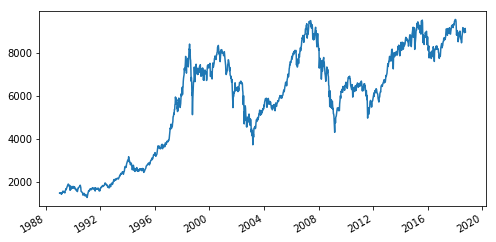

In [55]:
df[df.index.dayofweek == 0]['Close'].plot(figsize=(8,4))

**Quiz:** Ein Plot mit dem Schlusskurs an allen Freitagen

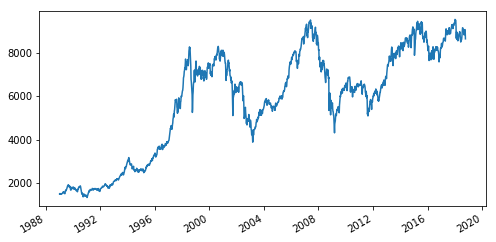

In [57]:
#Antwort
df[df.index.dayofweek == 4]['Close'].plot(figsize=(8,4))

**Quiz:** Ein Plot mit dem Schlusskurs an allen Freitagen von 2006 bis 2009

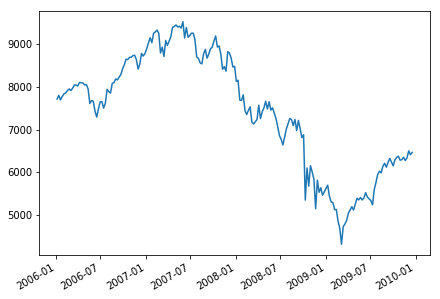

In [59]:
#Antwort
df["2006":"2009"][df["2006":"2009"].index.dayofweek == 4]["Close"].plot(figsize=(7,5))

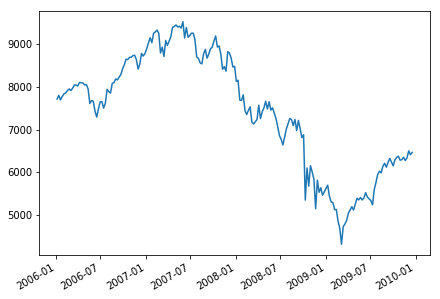

In [65]:
df[df.index.dayofweek == 4]["2006":"2009"]['Close'].plot(figsize=(7,5))

Ein Problem haben wir allerdings: Wie finden wir den letzten Tag eines Monats, bei dem Daten vorhanden sind?

In [63]:
df[df.index.is_month_end].head()

,Open,Close,High,Low
1989-01-31,1498.0,1490.5,1498.6,1484.9
1989-02-28,1434.0,1450.1,1451.5,1432.9
1989-03-31,1519.8,1527.7,1527.7,1519.8
1989-05-31,1517.4,1519.8,1523.5,1516.9
1989-06-30,1650.1,1638.9,1650.4,1638.5


## 3. Resampling

Die dritte Technik, die wir kennenlernen, heisst resampling. Wir fassen dabei bestimmte Zeitperioden zusammen. Was wir uns dabei überlegen müssen, ist:
- Welche Zeitperiode uns interessiert
- Welche Zusammenfassungs-Metrik wir bilden wollen
- (und allenfalls: welche Spalte uns interessiert)

**Beispiel:** Der Jahresdurchschnitt der SMI-Kurse. Das heisst also:
- Zeitperiode: jährlich
- Metrik: Durchschnitt
- Spalten: keine spezielle Auswahl

In [66]:
df.resample('A').mean().head()

# .resample ("A") A ist der Code fürs Jahr. mean() Durchschnitt

,Open,Close,High,Low
1989-12-31,1653.765587,1654.872874,1670.093004,1643.906639
1990-12-31,1616.343145,1614.733065,1625.970161,1604.979757
1991-12-31,1639.309677,1640.383871,1650.802823,1631.158300
1992-12-31,1853.182937,1854.954365,1876.682400,1844.190079
1993-12-31,2376.807087,2379.872835,2392.026378,2365.780709


Für einen Plot können wir zB eine Spalte speziell auswählen:

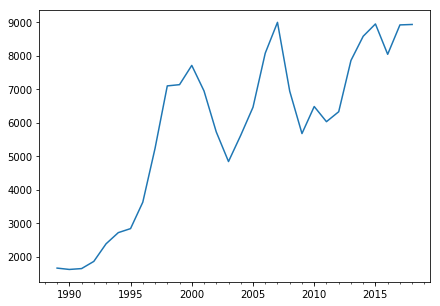

In [68]:
df.resample('A').mean()['Close'].plot(figsize=(7,5))

Hier eine Liste von manchen Zeitperioden, nach denen wir Resamplen können.
(Quelle/volle Liste: http://stackoverflow.com/a/17001474)

| Code | Meaning |
|---------|-----------|
| B       | business day frequency |
| D       | calendar day frequency |
| W       | weekly frequency |
| M       | month end frequency |
| BM      | business month end frequency |
| MS      | month start frequency |
| BMS     | business month start frequency |
| Q       | quarter end frequency |
| BQ      | business quarter endfrequency |
| QS      | quarter start frequency |
| BQS     | business quarter start frequency |
| A       | year end frequency |
| BA      | business year end frequency |
| AS      | year start frequency |
| BAS     | business year start frequency |

**Beispiel: ** Monatliche Mittelwerte

In [69]:
df.resample('M').mean().head()

,Open,Close,High,Low
1989-01-31,1487.571429,1489.909524,1494.080952,1482.542857
1989-02-28,1481.065000,1479.310000,1485.300000,1473.055000
1989-03-31,1500.280952,1503.723810,1508.552381,1498.270000
1989-04-30,1562.710526,1563.384211,1575.244444,1554.373684
1989-05-31,1526.463158,1524.157895,1529.977778,1518.105556


**Beispiel: ** Monatliche Mittelwerte, aber mit dem Monats-Startdatum statt mit dem Enddatum

In [70]:
df.resample('MS').mean().head()

,Open,Close,High,Low
1989-01-01,1487.571429,1489.909524,1494.080952,1482.542857
1989-02-01,1481.065000,1479.310000,1485.300000,1473.055000
1989-03-01,1500.280952,1503.723810,1508.552381,1498.270000
1989-04-01,1562.710526,1563.384211,1575.244444,1554.373684
1989-05-01,1526.463158,1524.157895,1529.977778,1518.105556


**Beispiel: ** Monatliche Maximalwerte

In [71]:
df.resample('MS').max().head()

,Open,Close,High,Low
1989-01-01,1505.4,1505.3,1511.1,1503.7
1989-02-01,1492.5,1493.2,1495.1,1489.1
1989-03-01,1524.8,1527.7,1527.7,1519.8
1989-04-01,1590.9,1588.5,1600.8,1584.5
1989-05-01,1576.6,1561.2,1577.5,1558.2


**Beispiel: ** Monatliche Anzahl

In [72]:
df.resample('MS').count().head()

,Open,Close,High,Low
1989-01-01,21,21,21,21
1989-02-01,20,20,20,20
1989-03-01,21,21,21,20
1989-04-01,19,19,18,19
1989-05-01,19,19,18,18


**Beispiel: ** Monatlicher Letztwert (-> das haben wir vorher gesucht!)

In [73]:
df.resample('MS').last().head()

,Open,Close,High,Low
1989-01-01,1498.0,1490.5,1498.6,1484.9
1989-02-01,1434.0,1450.1,1451.5,1432.9
1989-03-01,1519.8,1527.7,1527.7,1519.8
1989-04-01,1553.6,1576.9,1578.0,1553.6
1989-05-01,1517.4,1519.8,1523.5,1516.9


**Beispiel:** Wir können das Intervall "Jahr" auch nur in Fünferschritten abfragen

In [74]:
df.resample('5AS').mean()

,Open,Close,High,Low
1989-01-01,1830.739071,1831.832506,1846.514562,1822.040129
1994-01-01,4297.814992,4300.122648,4331.420494,4267.496093
1999-01-01,6471.825935,6468.076420,6517.650605,6418.592848
2004-01-01,7207.172143,7205.677746,7248.102595,7161.147746
2009-01-01,6467.187258,6466.926733,6504.002361,6427.817472
2014-01-01,8667.821697,8667.132579,8708.478278,8623.120948
2019-01-01,NaN,NaN,NaN,NaN


**Quiz:** Quartalsweise Minima (mit Startdatum als Index) - Liste

In [75]:
#Antwort
df.resample("QS").min().head()

,Open,Close,High,Low
1989-01-01,1434.0,1433.6,1451.5,1427.6
1989-04-01,1493.5,1494.2,1499.2,1477.9
1989-07-01,1641.2,1653.1,1653.1,1606.9
1989-10-01,1626.2,1622.9,1656.3,1614.7
1990-01-01,1620.8,1620.2,1621.9,1600.3


**Quiz:** Wöchentlicher Median aller Schlusskurse im Jahr 2017 - Plot

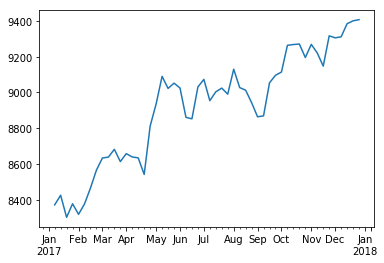

In [77]:
# Antwort
df["2017"]["Close"].resample("W").median().plot()

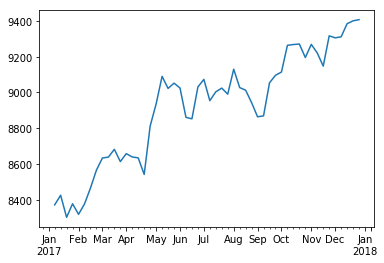

In [76]:
df["2017"].resample("W").median()["Close"].plot()

## 4. Grouping

Die vierte Technik, die wir kennenlernen, kennen wir eigentlich bereits: Groupby.

Hier geht es um zyklische Analysen, also zB Zusammenfassungen davon, was jeweils im Januar (egal welchen Jahres) passiert ist.

Was wir uns wiederum überlegen müssen, ist:
- Welcher Zeitintervall interessiert uns
- Welche Metrik wollen wir anwenden
- (und auf welche Spalte wollen wir das einschränken)


**(Kann zum Beispiel für Quartalszahlen verwendet werden)**

Technisch gesehen gruppieren wir die Daten eigentlich immer nach bestimmten, repetitiven Werten, die wir dem Index entnehmen:

In [78]:
df.index.month

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
           dtype='int64', length=7480)

Wir gruppieren die Daten also zB nach den Zahlen 1, 2, 3, .... 12, wenn wir nach Monat gruppieren

In [79]:
df.groupby(df.index.month).mean()

,Open,Close,High,Low
1,5737.231495,5732.842605,5772.236897,5695.258682
2,5735.458083,5734.317339,5767.708380,5707.509785
3,5736.523318,5737.679739,5776.150399,5707.224446
4,5849.537203,5851.412661,5889.814669,5814.642932
5,5904.195583,5903.460783,5943.526444,5876.647329
6,5835.082401,5833.176550,5868.483990,5799.035135
7,5863.779397,5864.363409,5904.817598,5840.471225
8,5855.390278,5853.068395,5894.456883,5819.258037
9,5832.797771,5829.751319,5869.205432,5790.875071
10,5735.209801,5736.843650,5774.860353,5693.718206


Wir können die gruppierte Auswertung wiederum plotten, wobei wir hier keine Line- sondern Barcharts verwenden sollten!

(das Ergebnis sieht jetzt nicht so spektakulär aus, aber das ändern wir später noch!)

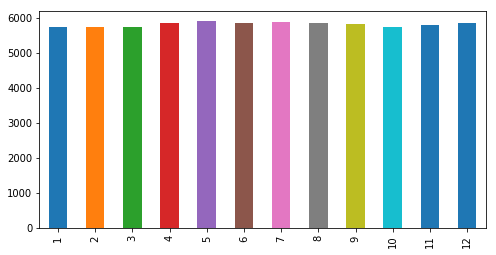

In [80]:
df.groupby(df.index.month)['Close'].mean().plot(figsize=(8,4), kind='bar')

**Beispiel:** Was war der höchste Börsenkurs, der je an einem Montag, Dienstag, ... Freitag erzielt wurde? Liste

In [81]:
df.groupby(df.index.dayofweek)['High'].max()

0    9584.52
1    9611.61
2    9616.38
3    9567.69
4    9561.59
Name: High, dtype: float64

**Quiz:** Ein Jahr hat 52 Wochen. Gibt es ein typisches Muster, wie sich die mittleren Schlusskurse entwickeln? Plot

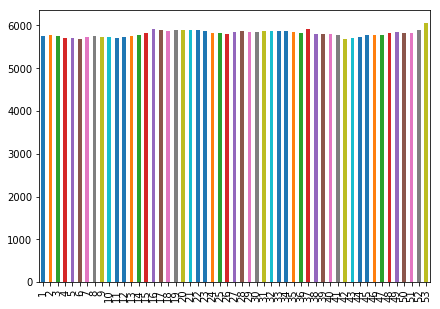

In [82]:
#Antwort
df.groupby(df.index.week)["Close"].mean().plot(figsize=(7,5), kind="bar")

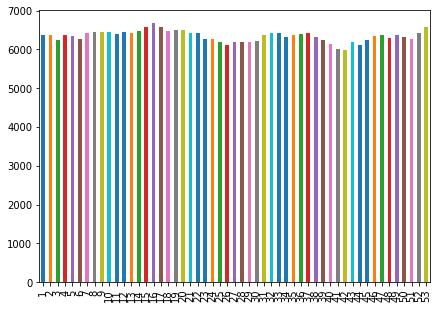

In [83]:
df.groupby(df.index.week)["Close"].median().plot(figsize=(7,5), kind='bar')


## 6. Percent change

Die Fragen, die wir soeben gestellt haben, werden einiges lustiger zu beantworten, wenn wir nicht die absoluten Kurse vergleichen (zB je nach Monat), sondern die relativen Veränderungen.

Dafür ist `pct_change()` da: Eine Funktion, die man auf das ganze Dataframe anwenden kann, um die täglichen, prozentualen Veränderungen auszurechen.

Oder man kann `pct_change()` auch auf Daten anwenden, die man bereits resamplet hat!

**Beispiel:** Wie verändert sich die Börse typischerweise über die Jahresmonate hinweg?

Wir starten dazu mit den monatlichen Mittelwerten für den ganzen Zeitraum, die wir mittels `resample()` bereits einmal ermittelt haben:

In [84]:
df.resample('MS').mean().head()

,Open,Close,High,Low
1989-01-01,1487.571429,1489.909524,1494.080952,1482.542857
1989-02-01,1481.065000,1479.310000,1485.300000,1473.055000
1989-03-01,1500.280952,1503.723810,1508.552381,1498.270000
1989-04-01,1562.710526,1563.384211,1575.244444,1554.373684
1989-05-01,1526.463158,1524.157895,1529.977778,1518.105556


Nun berechnen wir die monatlichen Veränderungsraten (warum ist die erste Spalte = NaN?)

In [85]:
df_mth_chg = df.resample('MS').mean().pct_change()

In [86]:
df_mth_chg.head()

,Open,Close,High,Low
1989-01-01,NaN,NaN,NaN,NaN
1989-02-01,-0.004374,-0.007114,-0.005877,-0.006400
1989-03-01,0.012974,0.016504,0.015655,0.017117
1989-04-01,0.041612,0.039675,0.044209,0.037446
1989-05-01,-0.023195,-0.025091,-0.028736,-0.023333


Letzter Schritt: Wir gruppieren die monatlichen Veränderungsraten - nach Monaten. Und mitteln.

In [87]:
df_mth_chg.groupby(df_mth_chg.index.month).mean()

,Open,Close,High,Low
1,0.012596,0.011623,0.012796,0.010786
2,0.003211,0.003611,0.002748,0.004337
3,0.001571,0.001985,0.004785,0.001323
4,0.017050,0.017055,0.013981,0.017527
5,0.012087,0.011932,0.012015,0.012233
6,0.000040,-0.000256,0.000124,-0.000121
7,0.005317,0.005551,0.005459,0.005249
8,-0.001212,-0.001702,0.000703,-0.002689
9,-0.006066,-0.006234,-0.007658,-0.005757
10,-0.001697,-0.000793,-0.000977,-0.001474


Im Plot der Schlusskurse sieht das dann so aus:

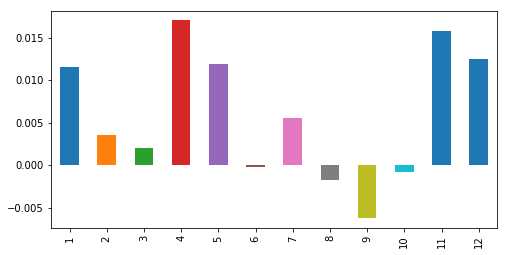

In [88]:
df_mth_chg.groupby(df_mth_chg.index.month)['Close'].mean().plot(figsize=(8,4), kind='bar')

"Sell in May and go away", lautet eine Börsenweisheit. Stimmt sie?

## 6. Rolling

Die sechste Technik, wie wir die Daten modifizieren können, ist: Rollen.

Wir schauen diese Technik nicht genauer an. Es geht darum:
- über ein bestimmtes Zeitfenster (zB 10 Tage)
- eine bestimmte Metrik anzuwenden
- (auf eine Spalte, falls wir wollen)

Hier wäre ein Anwendungsbeispiel: der gleitende ("rollende") Zehn-Tages-Durchschnitt der Börsenkurse. Wir müssen jeweils angeben, wie das Zeitfenster positioniert werden soll (zentriert oder nicht).

Mehr Infos: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html

In [89]:
df.rolling(10, center=True).mean().head(20)

,Open,Close,High,Low
1989-01-03,NaN,NaN,NaN,NaN
1989-01-04,NaN,NaN,NaN,NaN
1989-01-05,NaN,NaN,NaN,NaN
1989-01-06,NaN,NaN,NaN,NaN
1989-01-09,NaN,NaN,NaN,NaN
1989-01-10,1482.96,1489.60,1492.46,1480.44
1989-01-11,1489.88,1491.63,1496.37,1485.08
1989-01-12,1491.98,1493.08,1497.91,1486.29
1989-01-13,1493.14,1492.38,1498.07,1486.83
1989-01-16,1492.47,1491.30,1497.03,1485.69


# Plotting Level 3

Hier lernen wir:
- Einen Befehl, der ein paar Codezeilen spart: `agg()`
- Erstmals eine Funktion aus Matplotlib direkt anzusteuern: `fill_between()`

**Aggregate**

Wir haben bereits kennengelernt, wie wir mehrere Linien auf einen Plot zeichnen können.

In diesem Fall geht das eigentlich ganz einfach: Wir schreiben einfach alle `plot()`-Befehle in die Zelle.

Zum Beispiel: Die monatlichen Maximal-, Minimal- und Durchschnittskurse (seit 2014).

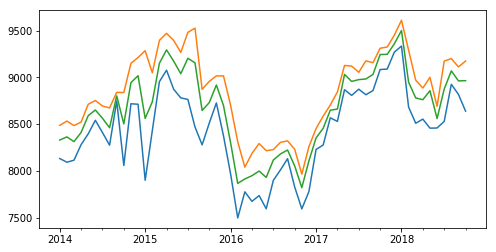

In [90]:
df['2014':].resample('MS').min()['Close'].plot(figsize=(8,4))
df['2014':].resample('MS').max()['Close'].plot()
df['2014':].resample('MS').mean()['Close'].plot()

Wir können die drei Metriken `min()`, `max()` und `mean()` aber auch in einen Befehl packen:

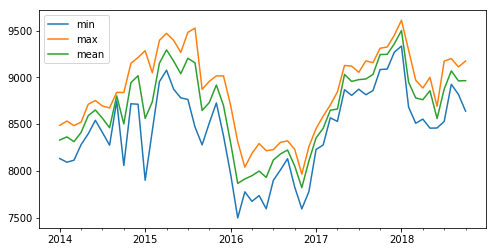

In [91]:
df['2014':].resample('MS').agg(['min', 'max', 'mean'])['Close'].plot(figsize=(8,4))

# .agg erlaubt es, die verschiedenen Datenreihen in einen Chart zu schreiben und auszugeben

Ohne Plot sehen wir, was dahinter steht:

In [92]:
df['2014':].resample('MS').agg(['min', 'max', 'mean'])['Close'].head()

,min,max,mean
2014-01-01,8132.16,8486.37,8329.420476
2014-02-01,8092.53,8532.99,8363.602500
2014-03-01,8114.02,8484.21,8312.969048
2014-04-01,8280.53,8521.63,8411.250000
2014-05-01,8395.77,8712.35,8590.655500


**Fill Between**

Bislang haben wir Plots stets mit der `plot()`-Funktion erstellt. Diese Funktion ist von verschiedenen Pandas-Objekttypen wie Series oder Dataframes her aufrufbar.

Die Matplotlib-Bibliothek bietet aber auch von sich aus Plotting-Funktionen an. Sie gehen zT weiter und erlauben uns mehr Möglichkeiten, Plots zu gestalten.

Um sie zu benutzen, müssen wir sie aber importieren. Konvention: als `plt`

In [93]:
#Brauchen wir zum plotten
import matplotlib.pyplot as plt

Eine Funktion, die wir aufrufen können, heisst: `fill_between()`. Sie benötigt drei Inputs:
- Eine Liste von x-Werten
- Eine Liste von y-Maximalwerten
- Eine Liste von y-Minimalwerten

Wir stellen diese Werte mal zusammen: Es sind dieselben wie bereits in der vorherigen Grafik.

In [95]:
x_values = df['2014':].resample('MS')['Close'].mean().index
y_mins = df['2014':].resample('MS')['Close'].min()
y_maxes = df['2014':].resample('MS')['Close'].max()

Dann füllen wir die Werte in die Funktion ein:

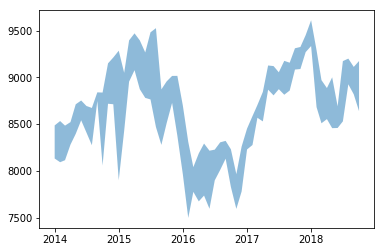

In [96]:
plt.fill_between(x_values, y_mins, y_maxes, alpha=0.5)

# alpha=x.x bedeutet soviel wie die Transparenz der hellen Farbe

In [98]:
plt.fill_between?

Wenn wir möchten, können wir zusätzlich noch die mittleren Werte dazuzeichnen:

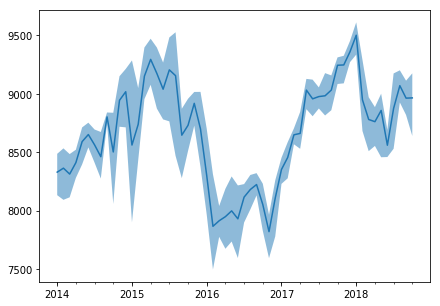

In [99]:
df['2014':].resample('MS').mean()['Close'].plot(figsize=(7,5))
plt.fill_between(x_values, y_mins, y_maxes, alpha=0.5)

# Übung

Wir waren bisher fast immer an den täglichen Schlusskursen interessiert. Nun schauen wir uns mal die täglichen Schwankungen an.

Wir bilden eine neue Spalte: Range = Differenz zwischen Tageshoch und -tief, in Prozent, gemessen am Schlusskurs.

In [100]:
df['Range'] = (df['High'] - df['Low']) / df['Close'] * 100

In [101]:
df.head(5)

,Open,Close,High,Low,Range
1989-01-03,1435.8,1466.2,1466.2,1435.8,2.073387
1989-01-04,1465.9,1471.2,1471.5,1465.7,0.394236
1989-01-05,1474.4,1488.1,1488.8,1473.7,1.014717
1989-01-06,1487.4,1487.3,1491.7,1483.4,0.558058
1989-01-09,1487.6,1493.5,1501.8,1487.3,0.970874


### Beginner

Ein paar Fragen zum Aufwärmen.

Erstellen Sie einen einfachen Plot mit den täglichen Schwankungswerten, für den gesamten Zeitraum.

Sieht das in Ordnung aus? Wählen Sie einen besseren Zeitraum, zB ab 1994:

Was sehen Sie auf dem Bild? Gab es Phasen, in denen die Schwankungen grösser waren?

In [ ]:
# Antwort als Text
# 

Stellen Sie denselben Chart dar, aber mit Schwankungen im Wochenmittel.

... und im Monatsmittel ...

... und im Quartalssmittel.

Welcher der vorherigen Charts sagt am meisten aus? Warum?

In [ ]:
# Antwort in Worten
# 

Plotten Sie die Tagesschwankung an allen Freitagen (immer noch ab 1994).

In [ ]:
df['1994':][df['1994':].index.weekday == 4]['Range'].plot(figsize=(8,4))

Vergleichen Sie diesen Chart mit dem Chart der Wochen-Durchschnittswerte. Welchen würden Sie verwenden? Warum?

In [ ]:
# Antwort in Worten
# 

### Advanced

Unterscheiden sich die Schwankungen je nach Monat? Plot, Daten ab 1994.

In [ ]:
# Antwort in Worten
# 

Steht die Höhe der Schwankungen in Zusammenhang mit dem Kursstand? Scatterplot, mit sehr kleinen Punkten.

In [ ]:
# Antwort in Worten
# 
# 

Erstellen Sie eine Rangliste der zehn Tage, an denen es die grössten Schwankungen gab. (ab 1994)

Dieselbe Rangliste, aber mit den Top 100. Plotten Sie diese auf einem Punkte-Diagramm:
- x: Zeitachse
- y: Höhe des Kurses.

Tipp: Attribute `linestyle=`, `marker=`, `markersize=` verwenden.
- Siehe https://stackoverflow.com/questions/8409095/matplotlib-set-markers-for-individual-points-on-a-line

Ihr Eindruck dieses Charts?

In [ ]:
# Antwort in Worten
# 

### Pro

Kreieren Sie drei Zeitreihen:
- Monatliche Serie von Datumsangaben: 1994-01-01, 1994-02-01, etc.
- Monatliches Schwankungsmaximum seit 1994
- Monatliches Schwankungsminimum seit 1994

Zeichnen Sie einen Fill-Between-Chart mit den drei Zeitreihen

Zeichnen Sie zusätzlich auf dem Chart eine Linie mit den monatlichen Schwankungs-Mittelwerten ein.